### Import Packages and Dependencies

In [20]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

### Pre-Processing Data

In [21]:
train_dir = 'train'
test_dir = 'test'

# resize images to 64x64 and select a subset of 2000 images from the training set to speed up performance
rows = 64
cols = 64
channels = 3

# for full data set
train_images = [train_dir + '/' + i for i in os.listdir(train_dir)]  

# separate cats and dogs for exploratory analysis
train_dogs = [train_dir + '/' + i for i in os.listdir(train_dir) if 'dog' in i]
train_cats = [train_dir + '/' + i for i in os.listdir(train_dir) if 'cat' in i]

test_images = [test_dir + '/' + i for i in os.listdir(test_dir)]


# select a subset of 2000 images from the training set to speed up performance
# Comment following three lines if using full dataset
train_images = train_dogs[:1000] + train_cats[:1000]
random.shuffle(train_images)
test_images =  test_images[:25]


def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (rows, cols), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, channels, rows, cols), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%500 == 0: print('Processed {} of {}'.format(i, count))
    return data

train = prep_data(train_images)
test = prep_data(test_images)

print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))


Processed 0 of 2000
Processed 500 of 2000
Processed 1000 of 2000
Processed 1500 of 2000
Processed 0 of 25
Train shape: (2000, 3, 64, 64)
Test shape: (25, 3, 64, 64)


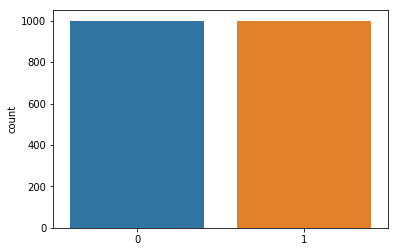

In [22]:
# add labels to images 0-for cats and 1-for dogs

labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)

In [23]:
# Model 1
input_shape = (3, rows, cols)

# model = Sequential()


# model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
# model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(16))
# model.add(Activation("relu"))
# model.add(Dropout(0.5))
# model.add(Dense(1))
# model.add(Activation("sigmoid"))

# model.compile(loss="binary_crossentropy",
#               optimizer="rmsprop",
#               metrics=["accuracy"])





# Model 2
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(data_format="channels_first", pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))
    
model.compile(loss='binary_crossentropy',
            optimizer=RMSprop(lr=0.0001),
            metrics=['accuracy'])

### Training and Predictions

In [27]:
epochs = 20
batch_size = 16

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, epochs=epochs,
              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

    predictions = model.predict(test, verbose=0)
    return predictions, history

predictions, history = run_catdog()


Epoch 00009: early stopping


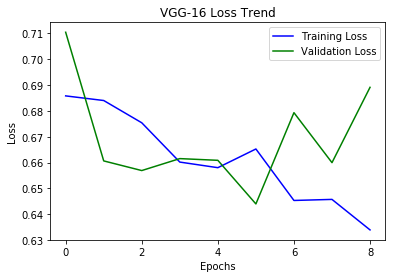

In [28]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

I am 86.26% sure this is a Cat


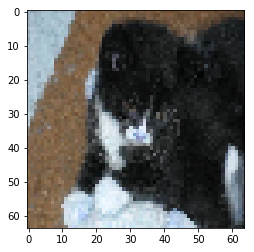

I am 77.85% sure this is a Cat


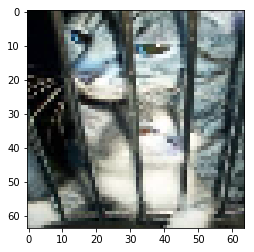

I am 66.31% sure this is a Dog


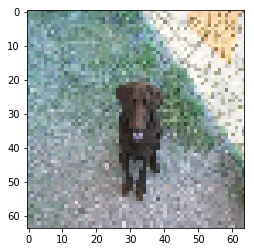

I am 54.57% sure this is a Dog


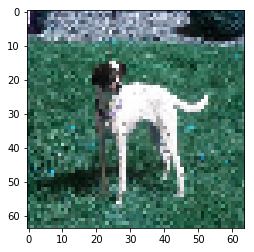

I am 70.62% sure this is a Cat


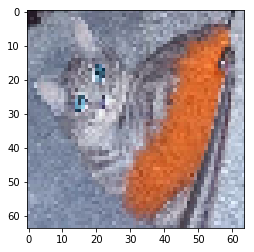

I am 61.24% sure this is a Dog


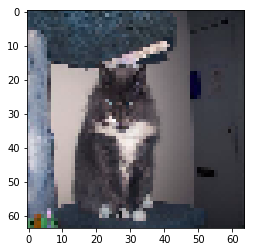

I am 51.03% sure this is a Cat


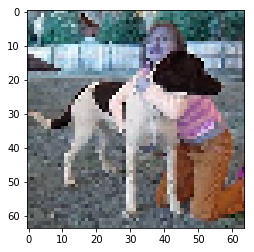

I am 77.89% sure this is a Dog


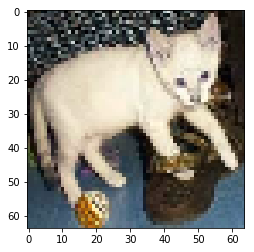

I am 52.02% sure this is a Cat


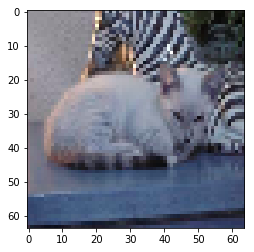

I am 66.87% sure this is a Dog


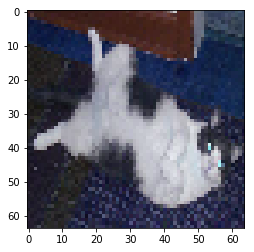

In [29]:
for i in range(0,10):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test[i].T)
    plt.show()
    